In [1]:
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [2]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

### A. Model Implementation and Training

In [3]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv, JumpingKnowledge, DeepGCNLayer

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:98: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperators

b. Load PubMed dataset


In [4]:
dataset = datasets.Planetoid(
    root="./",
    name='PubMed',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Implement Frobenius-normalized GCNConv layers

In [5]:
class FrobeniusNormGCNConv(GCNConv):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(FrobeniusNormGCNConv, self).__init__(in_channels, out_channels, **kwargs)

    def normalize_weights(self):
        # Access the weight matrix from the parameters
        weight = self.lin.weight  # GCNConv uses a linear layer internally
        frobenius_norm = weight.data.norm(p='fro')  # Compute the Frobenius norm
        weight.data /= frobenius_norm  # Normalize the weight matrix

    def forward(self, x, edge_index):
        # Normalize weights before the forward pass
        self.normalize_weights()
        return super(FrobeniusNormGCNConv, self).forward(x, edge_index)

### GCN BASELINE MODEL

In [6]:
class GCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3):
    super(GCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.n_classes = n_classes
    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio
    self.layers = nn.ModuleList()


    if self.n_layers == 0:
      self.layers.append(nn.Linear(self.input_dim, self.n_classes))
    else:
      self.layers.append(FrobeniusNormGCNConv(self.input_dim, self.hid_dim))
      for i in range(self.n_layers - 1):
        self.layers.append(FrobeniusNormGCNConv(self.hid_dim, self.hid_dim))
      self.layers.append(nn.Linear(self.hid_dim, self.n_classes))

  def forward(self, X, A,training=True) -> torch.Tensor:
    for layer in self.layers[:-1]:
        X = layer(X, A)
        X = F.relu(X)
        X = F.dropout(X, self.dropout_ratio, training=training)

    X = self.layers[-1](X)

    return X

  def generate_node_embeddings(self, X, A, training=True) -> torch.Tensor:
    for layer in self.layers[:-1]:
      X = layer(X, A)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio, training=training)
    return X

  def param_init(self):
    for layer in self.layers:
      layer.reset_parameters()

#### `train` and `evaluate` functions for training a node classification model.

In [7]:
def train(
    params: typing.Dict
) -> torch.nn.Module:
  """
    This function trains a node classification model and returns the trained model object.
  """
  # set device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # load dataset
  data = dataset.data
  data = data.to(device)

  # Update parameters
  params["n_classes"] = dataset.num_classes # number of target classes
  params["input_dim"] = dataset.num_features # size of input features

  # Set a model
  if params['model_name'] == 'GCN':
      model = GCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
        ).to(device)
  elif params['model_name'] == 'SkipGCN':
      model = SkipGCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
      ).to(device)
  elif params['model_name'] == 'DropEdgeGCN':
      model = DropEdgeGCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        params["dropedge_rate"]
      ).to(device)
  elif params['model_name'] == 'SkipDropGCN':
      model = SkipDropGCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        params["dropedge_rate"]
      ).to(device)
  else:
      raise NotImplementedError

  model.param_init()
  optimizer = torch.optim.Adam(model.parameters(), lr=training_params["lr"], weight_decay=training_params["weight_decay"])
  loss = nn.CrossEntropyLoss()
  losses = []
  train_accuracies = []
  previous_acc = 0
  for epoch in range(training_params["epochs"]):
    model.train()
    optimizer.zero_grad()

    # COMPUTE TRAIN LOSS
    logits = model(data.x, data.edge_index,training=True)
    train_loss = loss(logits[data.train_mask], data.y[data.train_mask])
    losses.append(train_loss.item())

    train_loss.backward()
    optimizer.step()
    # COMPUTE TRAIN ACC
    train_acc = (logits[data.train_mask].max(1)[1] == (data.y[data.train_mask])).float().mean()
    train_accuracies.append(train_acc.item())
    val_acc = evaluate(model, data, data.val_mask)

    # EARLY STOPPING
    patience = patience + 1 if val_acc < previous_acc else 0
    previous_acc = val_acc
    if patience >= training_params["max_patience"]:
      break

    #PRINT
    if epoch % 10 == 0:
      print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
  return model, val_acc


In [8]:
def evaluate(
    model,
    data,
    mask
):
    model.eval()
    logits = model(data.x, data.edge_index, training=False)
    preds = logits[mask].max(1)[1]
    acc = (preds == data.y[mask]).sum().item() / mask.sum().item()
    return acc

#### d. Set training hyper-parameters

In [9]:
training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GCN",
    "dropedge_rate": 0.3
}


#### Train 5 GCN models with 0, 1, 2, 4 and 10 layers.

In [10]:
torch.manual_seed(123) # set seed
val_accuracies = {}

In [11]:
training_params["n_layers"] = 0
model_0_layer,acc_0_layer = train(training_params)

Epoch: 000, Train Loss: 1.0978, Train Acc: 0.4000, Val Acc: 0.4420
Epoch: 010, Train Loss: 1.0303, Train Acc: 0.9833, Val Acc: 0.6540
Epoch: 020, Train Loss: 0.9667, Train Acc: 1.0000, Val Acc: 0.6600
Epoch: 030, Train Loss: 0.9074, Train Acc: 1.0000, Val Acc: 0.6620
Epoch: 040, Train Loss: 0.8528, Train Acc: 1.0000, Val Acc: 0.6580
Epoch: 050, Train Loss: 0.8027, Train Acc: 1.0000, Val Acc: 0.6600
Epoch: 060, Train Loss: 0.7571, Train Acc: 1.0000, Val Acc: 0.6640
Epoch: 070, Train Loss: 0.7156, Train Acc: 1.0000, Val Acc: 0.6680
Epoch: 080, Train Loss: 0.6780, Train Acc: 1.0000, Val Acc: 0.6640
Epoch: 090, Train Loss: 0.6438, Train Acc: 1.0000, Val Acc: 0.6740


In [12]:
training_params["n_layers"] = 1
model_1_layer,acc_1_layer = train(training_params)

Epoch: 000, Train Loss: 1.1008, Train Acc: 0.3333, Val Acc: 0.3880
Epoch: 010, Train Loss: 1.0756, Train Acc: 0.8333, Val Acc: 0.7360


In [13]:
training_params["n_layers"] = 2
model_2_layer,acc_2_layer = train(training_params)

Epoch: 000, Train Loss: 1.0994, Train Acc: 0.3333, Val Acc: 0.3880
Epoch: 010, Train Loss: 1.0881, Train Acc: 0.5667, Val Acc: 0.4700
Epoch: 020, Train Loss: 1.0827, Train Acc: 0.5500, Val Acc: 0.4880


In [14]:
training_params["n_layers"] = 4
model_4_layer,acc_4_layer = train(training_params)

Epoch: 000, Train Loss: 1.0994, Train Acc: 0.3333, Val Acc: 0.4160
Epoch: 010, Train Loss: 1.0985, Train Acc: 0.3500, Val Acc: 0.3880
Epoch: 020, Train Loss: 1.0935, Train Acc: 0.4000, Val Acc: 0.4000
Epoch: 030, Train Loss: 1.0846, Train Acc: 0.5000, Val Acc: 0.3900
Epoch: 040, Train Loss: 1.0707, Train Acc: 0.4833, Val Acc: 0.3740


In [15]:
training_params["n_layers"] = 10
model_10_layer,acc_10_layer = train(training_params)

Epoch: 000, Train Loss: 1.0995, Train Acc: 0.3333, Val Acc: 0.1960
Epoch: 010, Train Loss: 1.0994, Train Acc: 0.3167, Val Acc: 0.3880


In [16]:
val_accuracies["GCN"] = [acc_0_layer,acc_1_layer,acc_2_layer,acc_4_layer,acc_10_layer]

In [17]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
  """
    Args:
      model: model object for generating features

    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
  """
  tsne = TSNE(n_components=2, random_state=0)
  data = dataset.data
  data = data.to("cpu")
  embeddings = model.generate_node_embeddings(data.x, data.edge_index, training=False)[data.val_mask]
  X = tsne.fit_transform(embeddings.detach().numpy())
  df = pd.DataFrame(X, columns=['dimension 1', 'dimension 2'])
  df['labels'] = data.y[data.val_mask].numpy()
  return df


#### c. Generate reduced embeddings for each model and save them in a dictionary object

In [19]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "2_layer": dimension_reduction(model_2_layer),
    "4_layer": dimension_reduction(model_4_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

#### Functions for the visualisation

In [20]:
def visualise(feature_dict: typing.Dict) -> None:
  fig, axs = plt.subplots(1, 5, figsize=(20, 5))

  # Hardcoded scatter plots for specific layers
  axs[0].scatter(feature_dict["0_layer"]["dimension 1"], feature_dict["0_layer"]["dimension 2"], c=feature_dict["0_layer"]["labels"], cmap='viridis', alpha=0.8)
  axs[0].set_title("0_layer")

  axs[1].scatter(feature_dict["1_layer"]["dimension 1"], feature_dict["1_layer"]["dimension 2"], c=feature_dict["1_layer"]["labels"], cmap='viridis', alpha=0.8)
  axs[1].set_title("1_layer")

  axs[2].scatter(feature_dict["2_layer"]["dimension 1"], feature_dict["2_layer"]["dimension 2"], c=feature_dict["2_layer"]["labels"], cmap='viridis', alpha=0.8)
  axs[2].set_title("2_layer")

  axs[3].scatter(feature_dict["4_layer"]["dimension 1"], feature_dict["4_layer"]["dimension 2"], c=feature_dict["4_layer"]["labels"], cmap='viridis', alpha=0.8)
  axs[3].set_title("4_layer")

  axs[4].scatter(feature_dict["10_layer"]["dimension 1"], feature_dict["10_layer"]["dimension 2"], c=feature_dict["10_layer"]["labels"], cmap='viridis', alpha=0.8)
  axs[4].set_title("10_layer")

  # Adjust layout
  plt.tight_layout()
  plt.show()

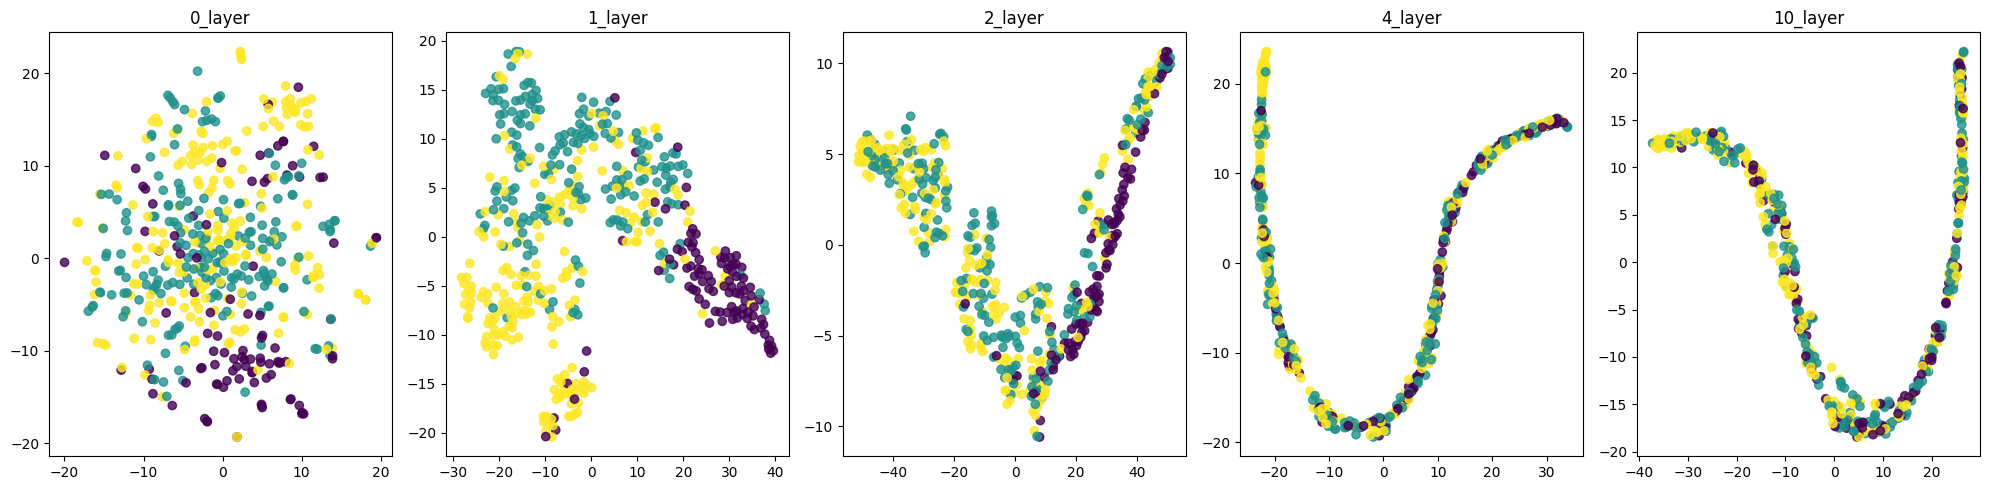

In [21]:
visualise(feature_dict)

#### GCN with Residual Connections


In [22]:
class SkipGCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3):
    super(SkipGCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
    """
    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.n_classes = n_classes
    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio
    self.layers = nn.ModuleList()
    if self.n_layers == 0:
      self.layers.append(nn.Linear(self.input_dim, self.n_classes))
    else:
      self.layers.append(FrobeniusNormGCNConv(self.input_dim, self.hid_dim))
      for i in range(self.n_layers - 1):
        self.layers.append(FrobeniusNormGCNConv(self.hid_dim, self.hid_dim))
      self.layers.append(nn.Linear(self.hid_dim, self.n_classes))

  def forward(self, X, A,training=True) -> torch.Tensor:
    if self.n_layers > 0:
      X = self.layers[0](X,A)
    skip = X
    for layer in self.layers[1:-1]:
        X = layer(X, A)
        X = F.relu(X)
        X = F.dropout(X, self.dropout_ratio, training=training)

        X = X + skip
        skip = X

    X = self.layers[-1](X)
    return X

  def generate_node_embeddings(self, X, A, training=True) -> torch.Tensor:
    if self.n_layers > 0:
      X = self.layers[0](X,A)
    skip = X
    for layer in self.layers[1:-1]:
      X = layer(X, A)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio, training=training)

      X = X + skip
      skip = X

    return X

  def param_init(self):
    for layer in self.layers:
      layer.reset_parameters()

#### b. Repeat experiments and Visualise the embeddings

In [23]:
torch.manual_seed(123) # set seed

In [24]:
training_params['model_name'] = 'SkipGCN'

training_params["n_layers"] = 0
model_0_layer,acc_0_layer = train(training_params)

training_params["n_layers"] = 1
model_1_layer,acc_1_layer = train(training_params)

training_params["n_layers"] = 2
model_2_layer,acc_2_layer = train(training_params)

training_params["n_layers"] = 4
model_4_layer,acc_4_layer = train(training_params)

training_params["n_layers"] = 10
model_10_layer,acc_10_layer = train(training_params)

val_accuracies["SkipGCN"] = [acc_0_layer,acc_1_layer,acc_2_layer,acc_4_layer,acc_10_layer]

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 000, Train Loss: 1.0978, Train Acc: 0.4000, Val Acc: 0.4420
Epoch: 010, Train Loss: 1.0303, Train Acc: 0.9833, Val Acc: 0.6540
Epoch: 020, Train Loss: 0.9667, Train Acc: 1.0000, Val Acc: 0.6600
Epoch: 030, Train Loss: 0.9074, Train Acc: 1.0000, Val Acc: 0.6620
Epoch: 040, Train Loss: 0.8528, Train Acc: 1.0000, Val Acc: 0.6580
Epoch: 050, Train Loss: 0.8027, Train Acc: 1.0000, Val Acc: 0.6600
Epoch: 060, Train Loss: 0.7571, Train Acc: 1.0000, Val Acc: 0.6640
Epoch: 070, Train Loss: 0.7156, Train Acc: 1.0000, Val Acc: 0.6680
Epoch: 080, Train Loss: 0.6780, Train Acc: 1.0000, Val Acc: 0.6640
Epoch: 090, Train Loss: 0.6438, Train Acc: 1.0000, Val Acc: 0.6740
Epoch: 000, Train Loss: 1.1007, Train Acc: 0.3333, Val Acc: 0.3880
Epoch: 010, Train Loss: 1.0752, Train Acc: 0.5833, Val Acc: 0.3780
Epoch: 020, Train Loss: 1.0632, Train Acc: 0.9667, Val Acc: 0.6620
Epoch: 030, Train Loss: 1.0517, Train Acc: 0.9333, Val Acc: 0.7360
Epoch: 040, Train Loss: 1.0402, Train Acc: 0.9667, Val Acc: 0.

In [25]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "2_layer": dimension_reduction(model_2_layer),
    "4_layer": dimension_reduction(model_4_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

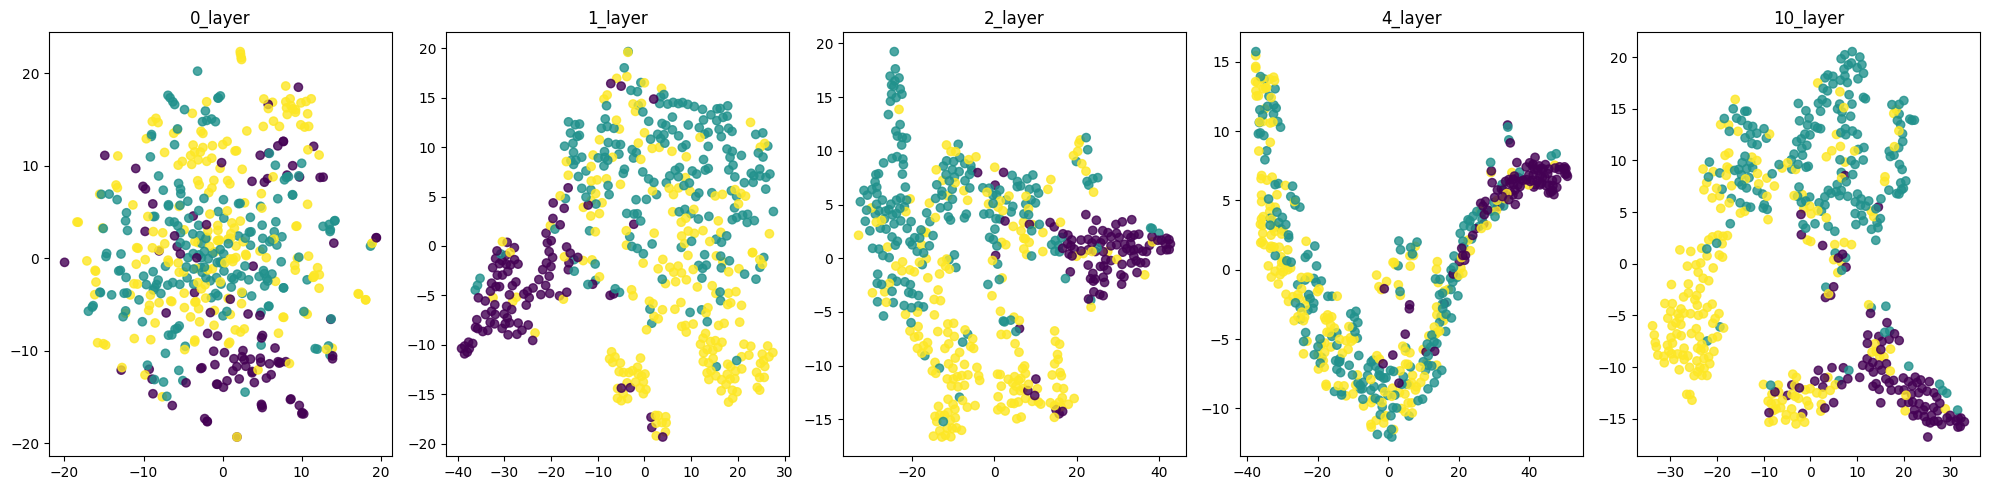

In [26]:
visualise(feature_dict)

#### Graph Convolutional Network with DropEdge


In [27]:
class DropEdgeGCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropedge_rate: float = 0.2,
      dropout_ratio: float = 0.3):
    super(DropEdgeGCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout ratio
      dropedge_rate: dropout edge rate
    """

    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.n_classes = n_classes
    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio
    self.dropedge_rate = dropedge_rate
    self.layers = nn.ModuleList()
    if self.n_layers == 0:
      self.layers.append(nn.Linear(self.input_dim, self.n_classes))
    else:
      self.layers.append(FrobeniusNormGCNConv(self.input_dim, self.hid_dim))
      for i in range(self.n_layers - 1):
        self.layers.append(FrobeniusNormGCNConv(self.hid_dim, self.hid_dim))
      self.layers.append(nn.Linear(self.hid_dim, self.n_classes))

  def drop_edge(self, edge_index, drop_rate):
        """
        Randomly drops edges in the adjacency matrix with the specified drop rate.
        Args:
          edge_index: COO edge index (torch.LongTensor of shape [2, num_edges])
          drop_rate: proportion of edges to drop
        Returns:
          Modified edge index
        """
        num_edges = edge_index.size(1) # Number of edges
        mask = torch.rand(num_edges) > drop_rate # Create a mask to keep edges with prob (1-p)
        return edge_index[:,mask] #Apply mask to edge_index


  def forward(self, X, A,training=True) -> torch.Tensor:
    for layer in self.layers[:-1]:
      edge_index = A
      if training:
          edge_index = self.drop_edge(edge_index, self.dropedge_rate)
      X = layer(X, edge_index)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio, training=training)

    X = self.layers[-1](X)

    return X

  def generate_node_embeddings(self, X, A, training=True) -> torch.Tensor:
    for layer in self.layers[:-1]:
      X = layer(X, A)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio, training=training)

    return X

  def param_init(self):
    for layer in self.layers:
      layer.reset_parameters()

#### b. Repeat experiments and Visualise the embeddings

In [28]:
training_params['model_name'] = 'DropEdgeGCN'
training_params['dropedge_rate'] = 0.3
torch.manual_seed(123)

training_params["n_layers"] = 0
model_0_layer,acc_0_layer = train(training_params)

training_params["n_layers"] = 1
model_1_layer,acc_1_layer = train(training_params)

training_params["n_layers"] = 2
model_2_layer,acc_2_layer = train(training_params)

training_params["n_layers"] = 4
model_4_layer,acc_4_layer = train(training_params)

training_params["n_layers"] = 10
model_10_layer,acc_10_layer = train(training_params)

val_accuracies["DropEdgeGCN"] = [acc_0_layer,acc_1_layer,acc_2_layer,acc_4_layer,acc_10_layer]

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 000, Train Loss: 1.0978, Train Acc: 0.4000, Val Acc: 0.4420
Epoch: 010, Train Loss: 1.0303, Train Acc: 0.9833, Val Acc: 0.6540
Epoch: 020, Train Loss: 0.9667, Train Acc: 1.0000, Val Acc: 0.6600
Epoch: 030, Train Loss: 0.9074, Train Acc: 1.0000, Val Acc: 0.6620
Epoch: 040, Train Loss: 0.8528, Train Acc: 1.0000, Val Acc: 0.6580
Epoch: 050, Train Loss: 0.8027, Train Acc: 1.0000, Val Acc: 0.6600
Epoch: 060, Train Loss: 0.7571, Train Acc: 1.0000, Val Acc: 0.6640
Epoch: 070, Train Loss: 0.7156, Train Acc: 1.0000, Val Acc: 0.6680
Epoch: 080, Train Loss: 0.6780, Train Acc: 1.0000, Val Acc: 0.6640
Epoch: 090, Train Loss: 0.6438, Train Acc: 1.0000, Val Acc: 0.6740
Epoch: 000, Train Loss: 1.1008, Train Acc: 0.3333, Val Acc: 0.3880
Epoch: 010, Train Loss: 1.0751, Train Acc: 0.8500, Val Acc: 0.6980
Epoch: 000, Train Loss: 1.1015, Train Acc: 0.3333, Val Acc: 0.3880
Epoch: 010, Train Loss: 1.0896, Train Acc: 0.6167, Val Acc: 0.6900
Epoch: 000, Train Loss: 1.1025, Train Acc: 0.3333, Val Acc: 0.

In [29]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "2_layer": dimension_reduction(model_2_layer),
    "4_layer": dimension_reduction(model_4_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

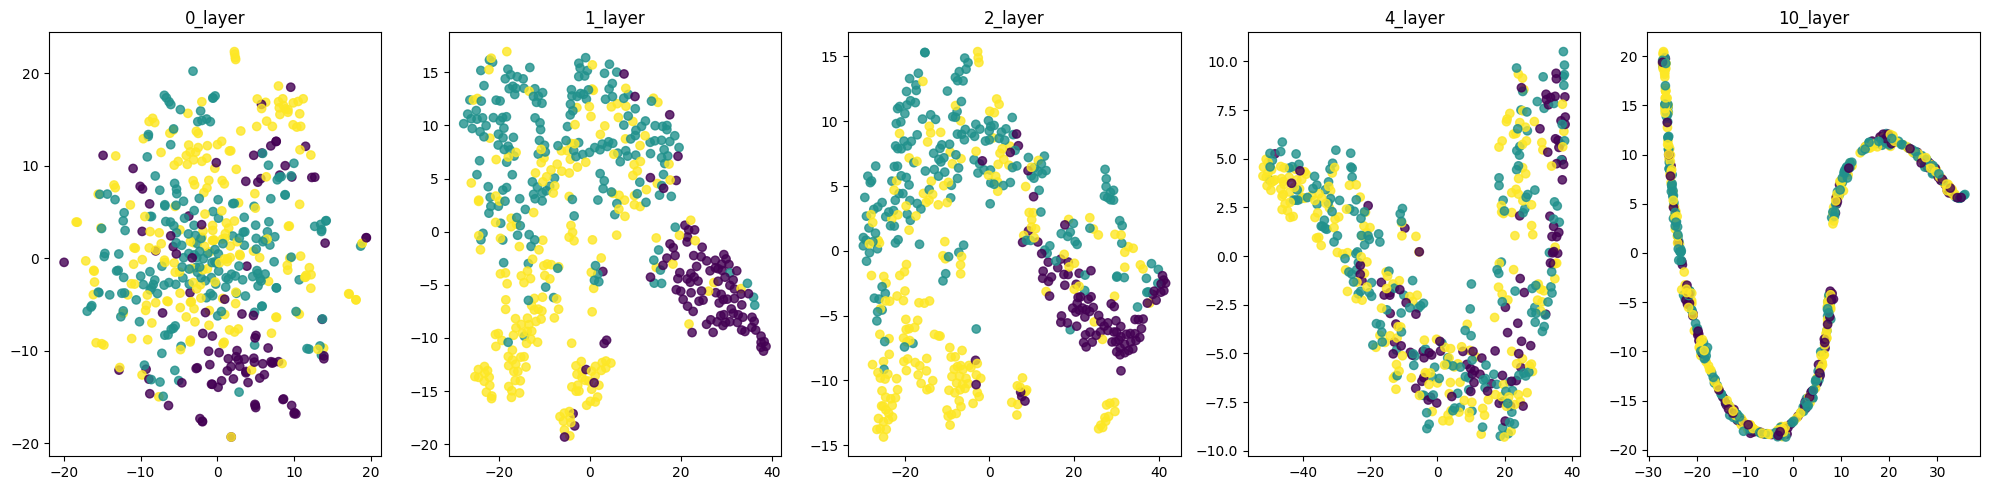

In [30]:
visualise(feature_dict)

### GCN + SkipConnections + DropEdge

In [31]:
class SkipDropGCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropedge_rate: float = 0.2,
      dropout_ratio: float = 0.3
      ):
    super(SkipDropGCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout ratio
      dropedge_rate: dropout edge rate
    """

    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.n_classes = n_classes
    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio
    self.dropedge_rate = dropedge_rate
    self.layers = nn.ModuleList()
    if self.n_layers == 0:
      self.layers.append(nn.Linear(self.input_dim, self.n_classes))
    else:
      self.layers.append(FrobeniusNormGCNConv(self.input_dim, self.hid_dim))
      for i in range(self.n_layers - 1):
        self.layers.append(FrobeniusNormGCNConv(self.hid_dim, self.hid_dim))
      self.layers.append(nn.Linear(self.hid_dim, self.n_classes))

  def drop_edge(self, edge_index, drop_rate):
        """
        Randomly drops edges in the adjacency matrix with the specified drop rate.
        Args:
          edge_index: COO edge index (torch.LongTensor of shape [2, num_edges])
          drop_rate: proportion of edges to drop
        Returns:
          Modified edge index
        """
        num_edges = edge_index.size(1) # Number of edges
        mask = torch.rand(num_edges) > drop_rate # Create a mask to keep edges with prob (1-p)
        return edge_index[:,mask] #Apply mask to edge_index


  def forward(self, X, A,training=True) -> torch.Tensor:
    if self.n_layers > 0:
      X = self.layers[0](X,A)
    skip = X
    for layer in self.layers[1:-1]:
      edge_index = A
      if training:
          edge_index = self.drop_edge(edge_index, self.dropedge_rate)
      X = layer(X, edge_index)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio, training=training)
      X = X + skip
      skip = X

    X = self.layers[-1](X)

    return X

  def generate_node_embeddings(self, X, A, training=True) -> torch.Tensor:
    if self.n_layers > 0:
      X = self.layers[0](X,A)
    skip = X
    for layer in self.layers[1:-1]:
      X = layer(X, A)
      X = F.relu(X)
      X = F.dropout(X, self.dropout_ratio, training=training)

      X = X + skip
      skip = X

    return X

  def param_init(self):
    for layer in self.layers:
      layer.reset_parameters()

In [32]:
training_params['model_name'] = 'SkipDropGCN'
training_params['dropedge_rate'] = 0.3
torch.manual_seed(123)

training_params["n_layers"] = 0
model_0_layer,acc_0_layer = train(training_params)

training_params["n_layers"] = 1
model_1_layer,acc_1_layer = train(training_params)

training_params["n_layers"] = 2
model_2_layer,acc_2_layer = train(training_params)

training_params["n_layers"] = 4
model_4_layer,acc_4_layer = train(training_params)

training_params["n_layers"] = 10
model_10_layer,acc_10_layer = train(training_params)

val_accuracies["SkipDropGCN"] = [acc_0_layer,acc_1_layer,acc_2_layer,acc_4_layer,acc_10_layer]

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 000, Train Loss: 1.0978, Train Acc: 0.4000, Val Acc: 0.4420
Epoch: 010, Train Loss: 1.0303, Train Acc: 0.9833, Val Acc: 0.6540
Epoch: 020, Train Loss: 0.9667, Train Acc: 1.0000, Val Acc: 0.6600
Epoch: 030, Train Loss: 0.9074, Train Acc: 1.0000, Val Acc: 0.6620
Epoch: 040, Train Loss: 0.8528, Train Acc: 1.0000, Val Acc: 0.6580
Epoch: 050, Train Loss: 0.8027, Train Acc: 1.0000, Val Acc: 0.6600
Epoch: 060, Train Loss: 0.7571, Train Acc: 1.0000, Val Acc: 0.6640
Epoch: 070, Train Loss: 0.7156, Train Acc: 1.0000, Val Acc: 0.6680
Epoch: 080, Train Loss: 0.6780, Train Acc: 1.0000, Val Acc: 0.6640
Epoch: 090, Train Loss: 0.6438, Train Acc: 1.0000, Val Acc: 0.6740
Epoch: 000, Train Loss: 1.1007, Train Acc: 0.3333, Val Acc: 0.3880
Epoch: 010, Train Loss: 1.0752, Train Acc: 0.5833, Val Acc: 0.3780
Epoch: 020, Train Loss: 1.0632, Train Acc: 0.9667, Val Acc: 0.6620
Epoch: 030, Train Loss: 1.0517, Train Acc: 0.9333, Val Acc: 0.7360
Epoch: 040, Train Loss: 1.0402, Train Acc: 0.9667, Val Acc: 0.

In [33]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "2_layer": dimension_reduction(model_2_layer),
    "4_layer": dimension_reduction(model_4_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

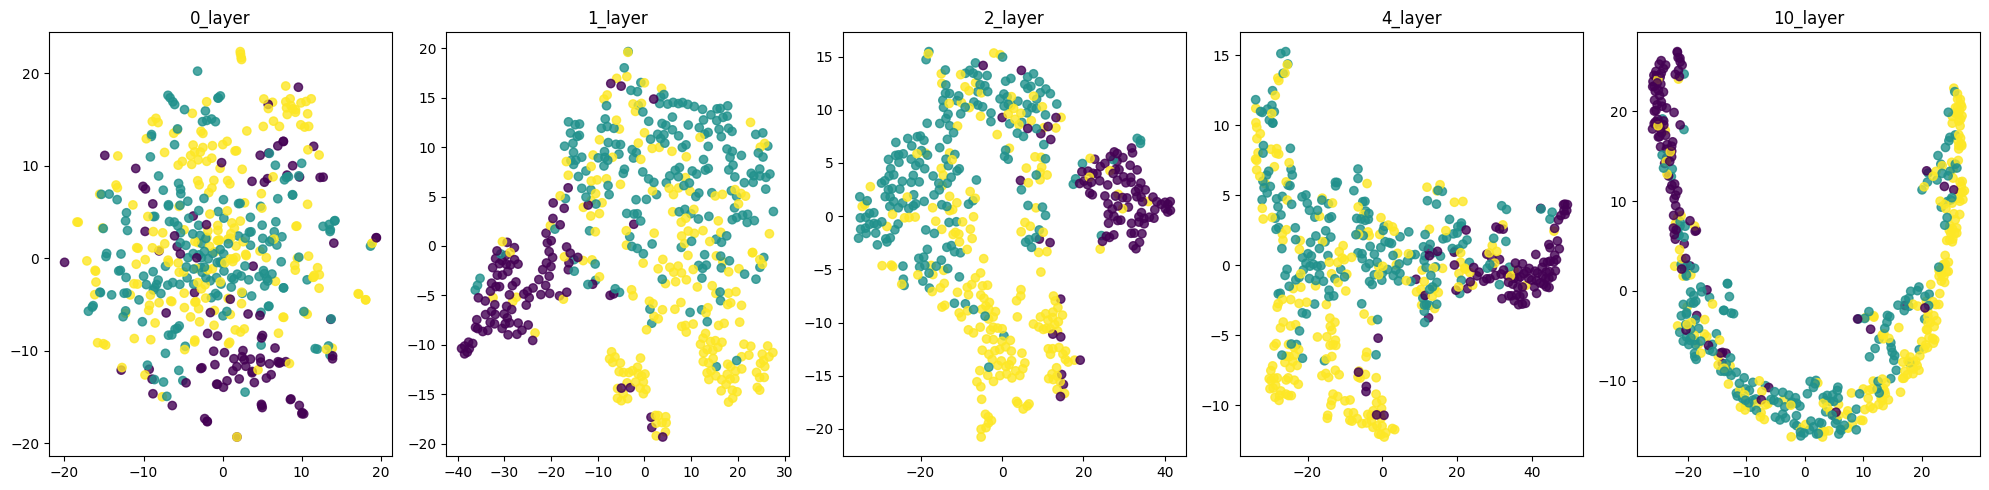

In [34]:
visualise(feature_dict)

In [35]:
def plot_accuracies(val_accuracies):
    """
    Plots the validation accuracies of different GNN models as a function of the number of layers.

    Args:
    val_accuracies (dict): A dictionary where the keys are model names and the values are lists
                            of validation accuracies for 0, 1, 3, 10, and 16 layers.
    """
    # Define the x-axis values representing the number of layers
    layers = [0, 1, 2, 4, 10]

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Plot each model's accuracies
    for model, accuracies in val_accuracies.items():
        plt.plot(layers, accuracies, marker='o', label=model)

    # Adding labels and title
    plt.xlabel('Number of Layers')
    plt.ylabel('Validation Accuracy')
    plt.title('CiteSeer')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

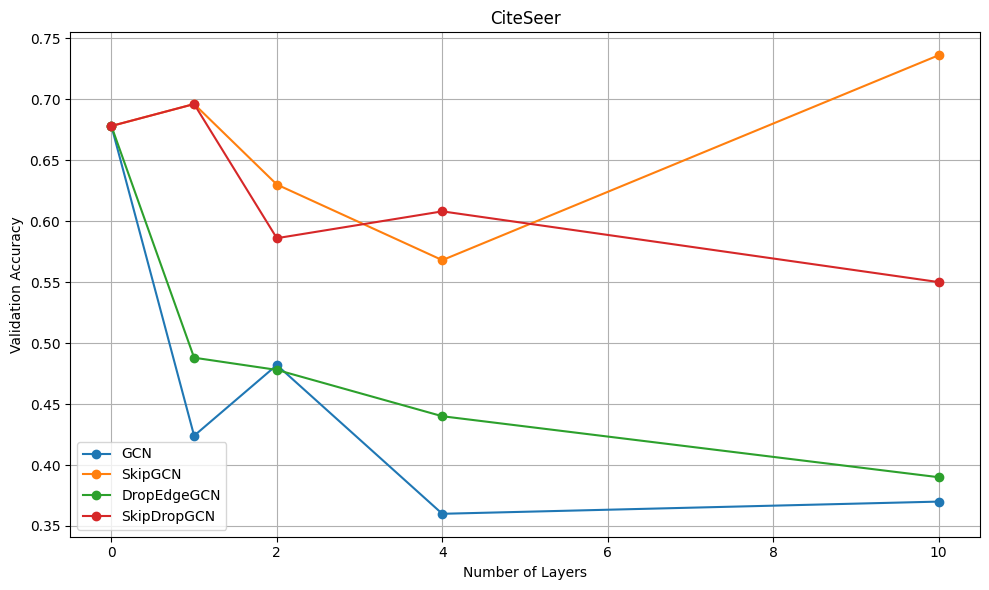

In [36]:
plot_accuracies(val_accuracies)